In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Temporal Difference Reinforcement Learning

So far, we only considered planning, meaning that we assumed that we know the underlying model of the environment and that the agent has access to it. 
Now, we considere the case in which do not have access to the full MDP. That is, we do __model-free prediction__ now.

To illustrate this, we implement the black jack example from the RL Lecture 4 by Davin Silver for Monte Carlo Reinforcement Learning [see example](https://youtu.be/PnHCvfgC_ZA?t=1003)

We learn directly from episodes of experience. We do that by determining how much reward we get for a given policy. Policy can be just a random walk. 

TD method properties:
* is model-free
* learns from incomplete episodes by bootstrapping
* updates a guess towards a guess

Simplest TD-learning algorithm TD(0):
* Update value $V(S_t)$ towards __estimated__ return $R_{t+1} + \gamma V(S_t)$

$$
V(S_t) \gets V(S_t) + \alpha ( R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
$$
where 
* $R_{t+1} + \gamma V(S_{t+1})$ is called __TD target__ (Estimated return)
* $\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ is called __TD error__ 

With TD one can react to different rewards within an episode. It updates the value function based on the prediction for the next time step.

TD converges to solution of maximum likelihood Markov model. It exploits the Markov property

_Bootstrapping:_ Update of the original guess by a guess later on in the episode (DP & TD use it)
_Sampling:_ An update samples an expectation. (MC & TD use it)

## TD($\lambda$) Algorithm

Let the _TD target_ look n steps into the future. Thus the n-step return is defined as
$$
G^{(n)}_T = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n+1} + \gamma^n V(S_{t+n})
$$

and the value update (n-step TD-learning):
$$
 V(S_t) \gets V(S_t) + \alpha (G^{(n)}_t - V(S_t))
$$

In TD($\lambda$) we want to combine all n-step lookaheads. For that we use the $\lambda$-return. That is, the geometrically weighted average of all n.
The weight is;

$$
 G^{\lambda}_t = (1-\lambda) \sum_{n=1} \lambda^{n-1} \cdot G^{(n)}_t
$$

and the value update :
$$
 V(S_t) \gets V(S_t) + \alpha (G^{\lambda}_t - V(S_t))
$$


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotting
plotting.set_layout(drawing_size=15)


## The Environment

For this example we use the python package [gym](https://gym.openai.com/docs/) which provides a ready-to-use implementation of a BlackJack environment.

The states are stored in this tuple format: (Agent's score , Dealer's visible score, and whether or not the agent has a usable ace)

Here, we can look at the number of different states:

In [6]:
import gym
env = gym.make('Blackjack-v0')
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

And the number of actions we can take:

In [7]:
env.action_space

Discrete(2)

To start a game call `env.reset()` which will return the obersavtion space

In [8]:
env.reset()

(19, 8, False)

We can take two different actions: `hit` = 1 or `stay` = 0. 

The result of this function call shows the _obersavtion space_, the reward (winning=+1, loosing =-1) and if the game is over, 

In [9]:
env.step(1)

((29, 8, False), -1.0, True, {})

## Define the Agent



In [84]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self, state_space, action_space, gamma=1, lamb=0.25, alpha = 0.005):
        """ TODO """ 
        
        # Store the discount factor 
        self.gamma = gamma
        # Store the lambda value
        self.lamb = lamb
        # Store the learning rate
        self.alpha = alpha
        
        n_player_states = state_space[0].n
        n_dealer_states = state_space[1].n
        n_usable_ace = state_space[0].n
        
        # two available actions stay (0) and hit (1)
        actions = range(action_space.n)
            
        # Store the value function for each state
        # start with zero
        self.v = np.zeros((n_player_states,n_dealer_states,n_usable_ace))
        
        # incremental counter for a state
        self.N = np.zeros((n_player_states,n_dealer_states,n_usable_ace))

    
    def random_move(self):
        # Do a random move, i.e. choose randomly 0 or 1
        return np.random.randint(0,2)
    
    
    def incre_counter(self, state):
        # Increments the counter for a given state
        
        # convert the true/false state to 0/1
        s2 = 1 if state[2] else 0
        # increment the counter for that state
        self.N[state[0],state[1],s2] += 1
    
    
    
    def policy_evaluation(self,all_states,all_rewards):
        # Doing policy evaluation using TD(lambda) learning
        for i_s,s in enumerate(all_states):

            # convert the true/false state to 0/1
            s2 = 1 if s[2] else 0
            # Get the value function for that state
            V_s = self.v[s[0],s[1],s2]
            # calculate the total reward for a given n of forward states
            Gs = []
            for i_r,r in enumerate(all_rewards):
                # calculate the total reward up for a given n of future states
                G = np.sum([agent.gamma**k * r for k,r in enumerate(all_rewards[:i_r+1])])
                Gs.append(G)
            # now calculate G^lambda
#             print([self.lamb**(n-1) * G for n,G in enumerate(Gs)])
            G_lamb = (1-self.lamb) * np.sum( [self.lamb**(n-1) * G for n,G in enumerate(Gs)])
            
            # Update the value funtion
            self.v[s[0],s[1],s2] = V_s + self.alpha * (G_lamb - V_s)

In [118]:
# how many episodes should be played
n_episodes = 50000
# initialize the agent. let it know the number of states and actions
agent = agents(env.observation_space, env.action_space)

# Incremental MC updates
# Play one episode then update V(s)
for i in range(n_episodes):
    all_states = []
    all_rewards = []
    
    # start the game
    s = env.reset()
    # save initiale states and update counter
    all_states.append(s)
    agent.incre_counter(s)

    # play until environment tells you that the game is over
    game_ended = False
    while not game_ended:
        # increment counter
        
        # Here, we follow a random policy
        move = agent.random_move()
         # End the game if sum of cards is >20
        if s[0] >= 20:
            move = 0
        else: 
            # otherwise do a random move. that should speed up the learning process
            move = 1 
        s,r,game_ended,_ = env.step(move)
    
        # save everything
        all_states.append(s)
        all_rewards.append(r)
        # increment the counter for a given state
        agent.incre_counter(s)

        # do the policy evaluation using TD learning
        agent.policy_evaluation(all_states,all_rewards)
    
        
    ### END OF EPISODE ###




## Plotting

<ipython-input-119-a81e167e6988>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-119-a81e167e6988>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))
<ipython-input-119-a81e167e6988>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-119-a81e167e6988>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))


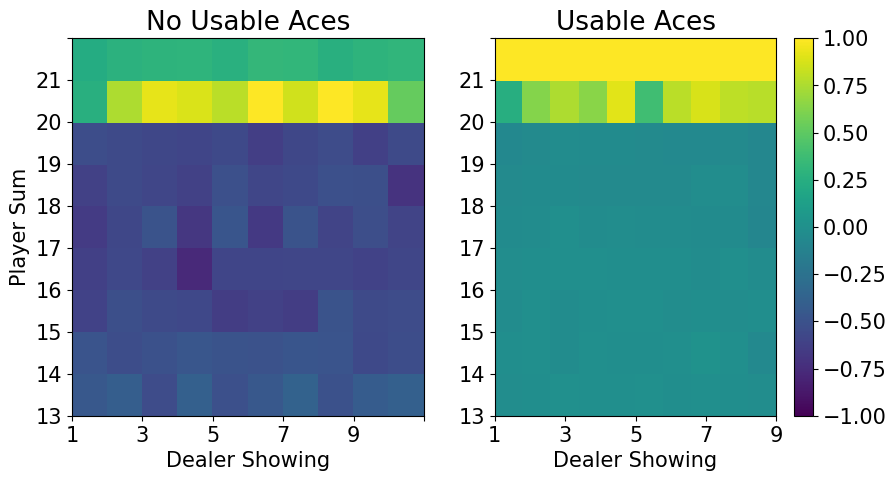

In [119]:
fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False)

ax = axes[0,0]


c = ax.pcolormesh(agent.v[13:22,1:,0],vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_title('No Usable Aces')
# plt.colorbar(c)

ax = axes[0,1]
c = ax.pcolormesh(agent.v[13:22,1:,1],vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_title('Usable Aces')
ax.set_xlabel('Dealer Showing')
plt.colorbar(c)

plt.show()

